# A05 Q2: Autoencoders

## Preliminaries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# In case you are fortunate enough to have access to a GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def plot_latent(h, t_class):
    '''
     plot_latent(h, t_class)
     Plots the 2D points in h, coloured according to their class.
    '''
    colours = ['pink', 'r', 'orange', 'tab:brown', 'y', 'g', 'teal', 'b', \
               'mediumpurple', 'gray', 'b']

    plt.figure(figsize=(7,6))
    for c in range(10):
        hh = h[t_class==c]
        if len(hh)>0:
            plt.scatter(hh[:,0], hh[:,1], c=colours[c], label=f'{c}')
    plt.axis('square');
    plt.legend(loc=(1.02, 0.5))
    plt.tight_layout();

# Dataset: MNIST

In [ ]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28

ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



In [ ]:
class MNIST(torch.utils.data.Dataset):
    def __init__(self, n=1024, img_size=28):
        '''
         ds = MNIST(n=1024, img_size=28)
         
         Creates an MNIST dataset of n digit images of the specified size.
         The images are converted to 1D vectors of size (img_size)**2.
        '''
        self.img_size = img_size
        self.n = n
        ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))
        ds_n = torch.utils.data.Subset(ds_full, range(self.n))
        self.x = ds_n

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        '''ds.__getitem__(idx) returns the image and class for a sample.
        '''
        x = self.x[idx][0]
        t = self.x[idx][1]
        return x, t
    
    def draw(self, x=None, idx=None):
        '''ds.draw(x=None, idx=None)
           Draws image x, or the image for index idx. If no argument is
           given, it chooses an index randomly.
        '''
        if x is not None:
            # Do nothing
            pass
        elif idx is not None:
            x = self.x[idx][0]
        else:
            r = np.random.randint(0, high=self.n)
            x = self.x[r][0]
        with torch.no_grad():
            plt.imshow(x.reshape((self.img_size, self.img_size)).detach().numpy(), cmap='gray');
            plt.axis('off');

In [ ]:
ds = MNIST()

In [ ]:
x, t = ds.__getitem__(12)

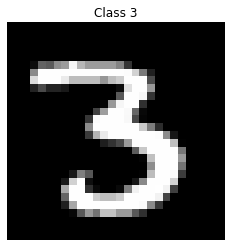

In [ ]:
plt.figure()
ds.draw(x=x)
plt.title(f'Class {t}');

## Create some `DataLoader`s

In [ ]:
# Batched, for training
batch_size_train = 20
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)

In [ ]:
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)

# A. Complete the `MyAE` class

In [ ]:
class MyAE(nn.Module):
    '''
     net = MyAE(img_size=28, embedding_dim=2)
     
     Create an autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images
                      Input samples will be (img_size**2) vectors.
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = MyAE()
       y = net(x)         # returns output
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, img_size=28, embedding_dim=2):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        
        #===== These lines are just placeholders =====
        #Encoder
        self.enc1 = nn.Linear(self.img_size**2, 256)
        self.enc2 = nn.Linear(256, 128)
        self.enc3 = nn.Linear(128, self.embedding_dim)
        #Decoder
        self.dec1 = nn.Linear(self.embedding_dim, 128)
        self.dec2 = nn.Linear(128, 256)
        self.dec3 = nn.Linear(256, self.img_size**2)

    def encode(self,x):
      x = torch.relu(self.enc1(x))
      x = torch.relu(self.enc2(x))
      h = self.enc3(x)
      return h
        
    def decode(self,h):
      h = torch.relu(self.dec1(h))
      h = torch.relu(self.dec2(h))
      y = torch.sigmoid(self.dec3(h))
      return y
        
    def forward(self, x):
        
        #===== YOUR CODE HERE =====
        h = self.encode(x)
        y = self.decode(h)
        return y


    
    def learn(self, dl, epochs=10, optimizer=None, loss_fcn=None):
        '''
         net.learn(dl, epochs=10, optimizer=None, loss_fcn=None)
         
         Train the network on the dataset delivered by the dataloader dl.
         
         Inputs:
          dl        DataLoader object
          epochs    number of epochs to train
          optimizer PyTorch optimizer function
          loss_fcn  PyTorch loss function
        '''
        if optimizer is None or loss_fcn is None:
            print('Need to specify an optimizer and loss function')
            return

        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                #x = x.to(device)   # for use with a GPU
                y = self(x)
                loss = loss_fcn(y, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()*len(t)
                count += 1.
            self.losses.append(total_loss/len(dl.dataset))

        plt.figure(figsize=(6,4))
        plt.plot(self.losses); plt.yscale('log');
        print("Final Loss:",self.losses[-1])

# B. Create and train the network

100%|██████████| 750/750 [08:52<00:00,  1.41it/s]


Final Loss: 0.01903558473713929


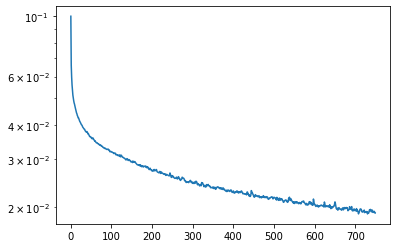

In [ ]:
net = MyAE(img_size=img_size, embedding_dim=2)
ds = MNIST()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
loss_fcn = nn.MSELoss()
n_epochs = 750
net.to(device)
net.learn(train_dl, epochs=n_epochs, optimizer=optimizer, loss_fcn=loss_fcn)



In [ ]:
# Uncomment the following line if you want to save your network.
torch.save(net.to('cpu'), 'my_AE.pt')
print(net)
# The corresponding code to reload the network is below.
# net = torch.load('my_AE.pt')
# Remember to send it to the GPU, if you're using one.
#net.to(device)

MyAE(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=128, bias=True)
  (dec2): Linear(in_features=128, out_features=256, bias=True)
  (dec3): Linear(in_features=256, out_features=784, bias=True)
)


AttributeError: ignored